In [2]:
import rasterio
import numpy as np
import os
import shutil
from matplotlib import pyplot as plt
from rasterio.plot import show
import glob
from os.path import join as opj

In [ ]:
# ### Data organization
# Goal is to resave files from their downloaded form into the following organization
# to ensure each label file can be matched with the planet data

# data  
#     / processed  
#         / labels  
#             / aoi (area of interest id)  
#                 / date.tif  
#         / planet  
#             / aoi  
#                 / date.tif  
#         / npz  
#             / labels  
#                 / aoi  
#                     date.npz  
#             / planet  
#                 / aoi  
#                     date.npz  

In [85]:
# Helper functions for resaving files
def copy_over_file(full_path, proc_dir, fldr):
    new_name = full_path[-14:]
    fldr_path = opj(proc_dir, fldr)
    if not os.path.exists(fldr_path):
        os.makedirs(fldr_path)
    shutil.copyfile(full_path, opj(fldr_path, new_name))

def make_main_dir(dirname):
    proc_data_dir = opj('data', 'processed',dirname)
    if not os.path.exists(proc_data_dir):
        os.makedirs(proc_data_dir)
    return proc_data_dir

### Labels

In [53]:
raw_path = 'data/raw/labels/labels/'
label_files = list({f for f in glob.glob(raw_path + "**/**/**.tif", recursive=True)})

In [38]:
proc_labels_dir = make_main_dir('labels')

for full_path in label_files:
    # Extract folder name
    fldr = full_path.replace(raw_path,"").split('/')[0]
    copy_over_file(full_path, proc_labels_dir, fldr)


In [56]:
#We should have (12 months * 2 years * 55 locations) .tif files
proc_path = 'data/processed/labels/'
proc_files = {f for f in glob.glob(proc_path + "**/**/**.tif", recursive=True)}
n_files = len(proc_files)
assert n_files == 55 * 24

# Remove labels and labels.zip
shutil.rmtree('data/raw/labels')
os.remove('data/raw/labels.zip')

### Planet files (training data)

In [88]:
raw_path = 'data/raw/'
planet_files = list({f for f in glob.glob(raw_path + "planet**/**/PF-SR/**.tif", recursive=True)})

In [89]:
proc_data_dir = make_main_dir('planet')

for full_path in planet_files:
    # remove last 21 chars
    aoi = full_path[-33:-21]
    digits = full_path.replace(raw_path + 'planet.', "")[:3]
    fldr = aoi+'_' + digits
    copy_over_file(full_path, proc_data_dir, fldr)
    

In [91]:
#We should have 2 * 365 .tif files
proc_path = 'data/processed/planet/'
proc_files = {f for f in glob.glob(proc_path + "**/**/**.tif", recursive=True)}
n_files = len(proc_files)
assert n_files == len(os.listdir(proc_path)) * 365 * 2

# Remove remaining raw data
shutil.rmtree('data/raw')

### Save as npz files

In [7]:
proc_path = opj('data','processed')

for type in ['planet']:
    for dir in os.listdir(opj(proc_path, type)):
        new_dir = opj('data', 'processed', 'npz', type, dir)
        if not os.path.exists(new_dir):
            os.makedirs(new_dir)
        for tif_file in os.listdir(opj(proc_path, type, dir)):
            tif_path = opj(proc_path, type, dir, tif_file)
            # read as np ndarrays
            tif_as_np = rasterio.open(tif_path).read()
            npz_path = opj(new_dir, tif_file).replace('.tif', '')
            np.savez_compressed(npz_path, tif_as_np)


In [ ]:
# TODO:
# Convert tif data files to uint8 to save storage 
# May need to nornmalize to RGB 0-255 first
# https://stackoverflow.com/questions/46866586/conversion-of-image-type-int16-to-uint8

### Explore dataset

In [94]:
# Label dataset info
def get_info(dataset):
    print("Number of bands:", dataset.count)
    print("Pixels width:", dataset.width)
    print("Pixels height:", dataset.height)
    print("Bounds:", dataset.bounds)
    print("CRS:", dataset.crs)
    print("NUMPY shape:", dataset.read().shape)
    print("NUMPY shape of one band:", dataset.read(1).shape)

def summarize_classes(dataset):
    for class_idx in range(dataset.count):
        print(f'''Class index: {class_idx}. \
            Type: {dataset.dtypes[class_idx]}. \
            Max: {np.max(dataset.read(class_idx+1))}. \
            Min: {np.min(dataset.read(class_idx+1))}. \
            Med: {np.median(dataset.read(class_idx+1))}''')

In [95]:
label_path = 'data/processed/labels/1700_3100_13_13N/2018_01_01.tif'
labels = rasterio.open(label_path)

get_info(labels)
print('')
summarize_classes(labels)

Number of bands: 7
Pixels width: 1024
Pixels height: 1024
Bounds: BoundingBox(left=475342.499999997, bottom=4429321.500000001, right=478414.499999997, top=4432393.500000001)
CRS: EPSG:32613
NUMPY shape: (7, 1024, 1024)
NUMPY shape of one band: (1024, 1024)

Class index: 0.             Type: uint8.             Max: 255.             Min: 0.             Med: 0.0
Class index: 1.             Type: uint8.             Max: 0.             Min: 0.             Med: 0.0
Class index: 2.             Type: uint8.             Max: 255.             Min: 0.             Med: 0.0
Class index: 3.             Type: uint8.             Max: 0.             Min: 0.             Med: 0.0
Class index: 4.             Type: uint8.             Max: 255.             Min: 0.             Med: 0.0
Class index: 5.             Type: uint8.             Max: 255.             Min: 0.             Med: 0.0
Class index: 6.             Type: uint8.             Max: 0.             Min: 0.             Med: 0.0


In [96]:
labels_np = labels.read()

In [98]:
np.savez_compressed('data/processed/npz/test_labels.npz', labels_np)

In [109]:
np.load('data/processed/npz/test_labels.npz')['arr_0']

array([[[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0, 255, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ..., 255, 255, 255],
        [  0,   0,   0, ..., 255, 255, 255],
        [  0,   0,   0, ..., 255, 255, 255]],

       [[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       [[255, 255, 255, ...,   0,   0,   0],
        [255, 255, 255, ...,   0,   0,   0],
        [255, 255,   0, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       ...,

       [[  0,   0,   0, ..., 255, 255, 255],
        [  0,   0,   0, ..., 255, 255, 255],
        [  0,   0,   0, ..., 255, 255, 255

In [4]:
# PF-SR contains Surface Reflective (data)
# QA contains metadata on data-gathering process
data_path = 'data/planet/13N/19E-184N/1700_3100_13/PF-SR/2018-01-01.tif'
data = rasterio.open(data_path)

get_info(data)
print('')
summarize_classes(data)

Number of bands: 4
Pixels width: 1024
Pixels height: 1024
Bounds: BoundingBox(left=475342.499999997, bottom=4429321.500000001, right=478414.499999997, top=4432393.500000001)
CRS: EPSG:32613
NUMPY shape: (4, 1024, 1024)
NUMPY shape of one band: (1024, 1024)

Class index: 0.             Type: int16.             Max: 5324.             Min: 149.             Med: 557.0
Class index: 1.             Type: int16.             Max: 4737.             Min: 174.             Med: 605.0
Class index: 2.             Type: int16.             Max: 5796.             Min: 164.             Med: 746.0
Class index: 3.             Type: int16.             Max: 4804.             Min: 721.             Med: 1539.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


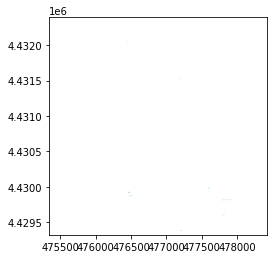

<AxesSubplot:>

In [23]:
show((data, [1,2,3]))

TypeError: Invalid shape (3, 1024, 1024) for image data

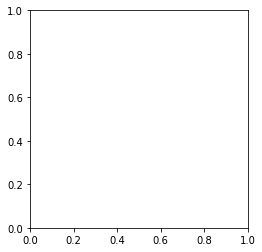

In [11]:
plt.imshow(data.read([1,2,3]) * 1e-4, cmap='pink')


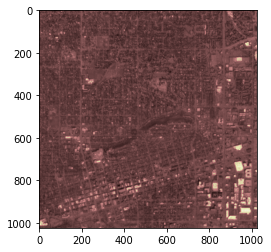

In [118]:
plt.imshow(data.read(2), cmap='pink')


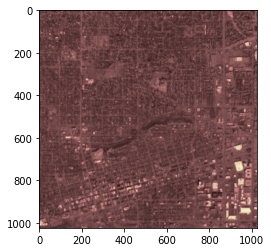

In [101]:
plt.imshow(data.read(3), cmap='pink')

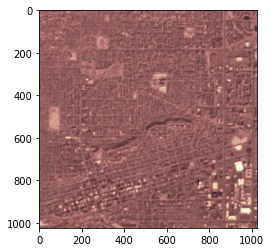

In [102]:
plt.imshow(data.read(4), cmap='pink')

### Plot labels - binary masks

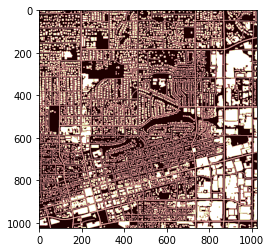

In [103]:
plt.imshow(labels.read(1), cmap='pink')

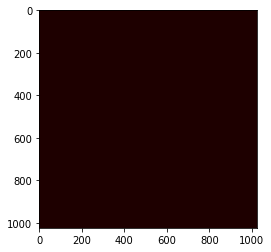

In [104]:
plt.imshow(labels.read(2), cmap='pink')

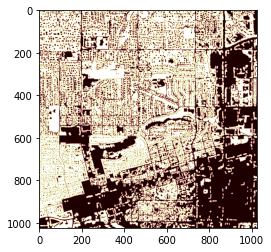

In [105]:
plt.imshow(labels.read(3), cmap='pink')

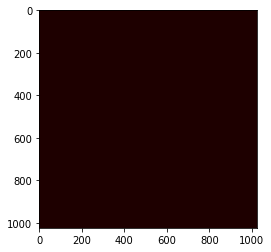

In [106]:
plt.imshow(labels.read(4), cmap='pink')

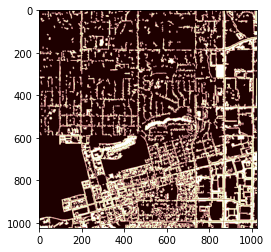

In [107]:
plt.imshow(labels.read(5), cmap='pink')

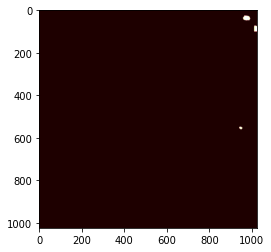

In [108]:
plt.imshow(labels.read(6), cmap='pink')

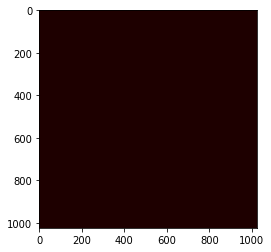

In [109]:
plt.imshow(labels.read(7), cmap='pink')